# Import Libraries

In [ ]:
# Information referenced from https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

# Import all necessary libraries 
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis Tools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Layers of Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet201, DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Warnings
import warnings

# Import Google Drive and Drive Mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My Drive/

# Inialise Data Directory
data_dir = '/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/'


# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Check CPU
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/gdrive
/content/gdrive/My Drive
Sat Mar 12 16:59:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                    

# Check Software Versions

In [ ]:
print("Tensorflow Version:", tensorflow.__version__)
print("Pandas Version:", pd.__version__)
print("NumPY Version:", np.__version__)
print("Keras Version:", keras.__version__)
print("CV2 Version:", cv2.__version__)
print("Seaborn Version:", sns.__version__)
!python --version

Tensorflow Version: 2.8.0
Pandas Version: 1.3.5
NumPY Version: 1.21.5
Keras Version: 2.8.0
CV2 Version: 4.1.2
Seaborn Version: 0.11.2
Python 3.7.12


# Create model top layers and configure fully-connected layer


In [ ]:
# https://github.com/experiencor/keras-yolo2/issues/167
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://keras.io/api/applications/densenet/

# Get and Install Model weights, set top, and image input size
waste_model=DenseNet201(weights='imagenet',include_top=False, input_shape=(100, 100, 3)) 

x=waste_model.output

# Add layers
x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

# Fully Connected Layer
preds=Dense(6,activation='softmax')(x) #Fully Connected-layer

74850304/74836368 [==============================] - 0s 0us/step


# Summary of Standard Model

In [ ]:
# Compress what was created and summarise model
model=Model(inputs=waste_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Set last 8 layers to trainable

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

# All layers parameters' set to trainable
#model.trainable=True

# Compile model and display new summary

In [ ]:
# Compile Model and display new summary
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

# Dataset Preparation: Sizing, Labels, and Arrays

In [ ]:
# Create dataset and label arrays
wastedata=[]
labels=[]

# Set Random Number generator
random.seed(42)

# Access waste images directory
wasteDirectory = sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/")))

# Shuffle the directory
random.shuffle(wasteDirectory)

# Print directory class names
print(wasteDirectory)

# Resize and sort images in directory in the case they haven't already
for img in wasteDirectory:
    pathDir=sorted(list(os.listdir("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/"+img)))
    for i in pathDir:
        imagewaste = cv2.imread("/content/gdrive/My Drive/Rivers V2/Datasets/Original Unmodified Dataset/"+img+'/'+i)
        imagewaste = cv2.resize(imagewaste, (100,100))
        imagewaste = img_to_array(imagewaste)

        # Assign dataset to data array
        wastedata.append(imagewaste)
        l = label = img

        # Append to labels array
        labels.append(l)

['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']


In [ ]:
# Use Numpy for floating point array on wastdata array
wastedata = np.array(wastedata, dtype="float32") / 255.0

# Labels in numpy array
labels = np.array(labels)

# Learn one binary classifer per waste classifer
bcw = LabelBinarizer()

# Implement on Labels
labels = bcw.fit_transform(labels)

# Print Binary Labels
print(labels[0])

[0 0 0 1 0 0]


In [ ]:
# Split train and test data up 60/40
(trainX,testX,trainY,testY)=train_test_split(wastedata,labels,test_size=0.4,random_state=42)

# Print train/test split
print(trainX.shape, testX.shape)

(960, 100, 100, 3) (640, 100, 100, 3)


In [ ]:
# Set Learning Rates and call backs
modCall = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

# Saving best Model
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Image Augmentation
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1, fill_mode="nearest")
datagen.fit(trainX)

# Train and Test the model
wasteImp = model.fit_generator(datagen.flow(trainX, trainY, batch_size=8),
               steps_per_epoch=trainX.shape[0] //8,
               epochs=30,
               verbose=2,
               callbacks=[modCall, checkpoint],
               validation_data=(trainX, trainY))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1: val_loss improved from inf to 1.23036, saving model to model.h5
120/120 - 27s - loss: 2.1860 - accuracy: 0.3656 - val_loss: 1.2304 - val_accuracy: 0.6177 - lr: 0.0010 - 27s/epoch - 224ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.23036 to 0.69140, saving model to model.h5
120/120 - 5s - loss: 1.5143 - accuracy: 0.4885 - val_loss: 0.6914 - val_accuracy: 0.7375 - lr: 0.0010 - 5s/epoch - 43ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.69140
120/120 - 4s - loss: 1.2983 - accuracy: 0.5385 - val_loss: 0.8058 - val_accuracy: 0.7115 - lr: 0.0010 - 4s/epoch - 31ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.69140 to 0.62413, saving model to model.h5
120/120 - 5s - loss: 1.1643 - accuracy: 0.5698 - val_loss: 0.6241 - val_accuracy: 0.7740 - lr: 0.0010 - 5s/epoch - 42ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.62413 to 0.59456, saving model to model.h5
120/120 - 5s - loss: 1.1370 - accuracy: 0.5875 - val_loss: 0.5946 - val_accuracy: 0.7760 - lr: 0.

In [ ]:
# Analysis of model test
yped = model.predict(testX)

# Set variables
totalTest = 0
accuratePre = 0
accurateind = []
wrongData = []

# Loop through results and decide correct or wrong
for i in range(len(yped)):
    if np.argmax(yped[i]) == np.argmax(testY[i]):
        accuratePre += 1
        accurateind.append(i)
    else:
        wrongData.append(i)
        
    totalTest += 1

# Display information to user
print('Total Test Dataset:', totalTest, '\tTotal Predicted Correct:', accuratePre, '\t Total Predicted Wrong: ', totalTest - accuratePre)
print('Overall Model Accuracy:', round(accuratePre/totalTest*100, 3), '%')

Total Test Dataset: 640 	Total Predicted Correct: 450 	 Total Predicted Wrong:  190
Overall Model Accuracy: 70.312 %


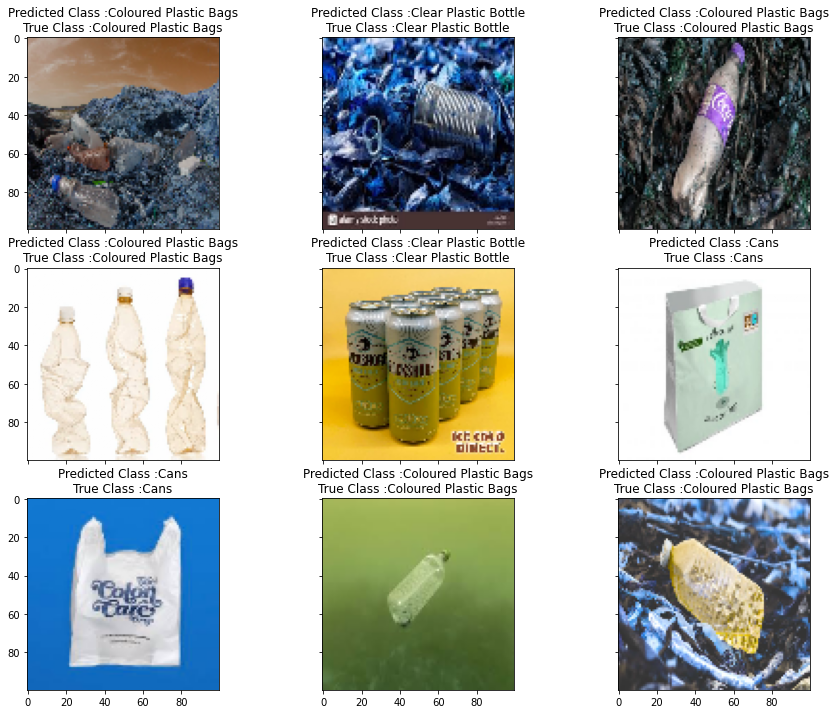

In [ ]:
# Sample Tests from classes and adjacent labels
label=['Clear Plastic Bottle', 'Clear Glass Bottle', 'Clear Plastic Bags', 'Coloured Plastic Bags', 'Cans', 'Coloured Plastic Bottle']
imidx = random.sample(accurateind, k=9)# replace with 'wrongData'/accurateind

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

# Testing Images
n = 0
for row in range(nrows):
    for col in range(ncols):
            axs[row,col].imshow(testX[imidx[n]])
            axs[row,col].set_title("Predicted Class :{}\nTrue Class :{}".format(label[np.argmax(yped[imidx[n]])], label[np.argmax(testY[imidx[n]])]))
            n += 1
# Show user feedback
plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

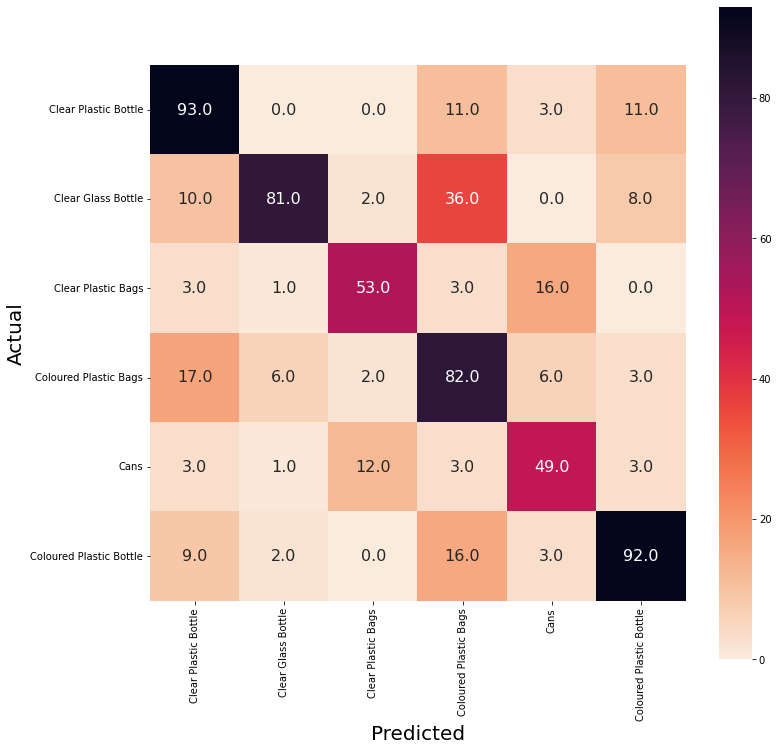

In [ ]:
# Confusion Matrix Creation
Yprd = model.predict(testX)

# X and Y of the Matrix
Yprd = np.argmax(Yprd, axis=1)
Ytru = np.argmax(testY, axis=1)

# Create the Confusion Matrix and variables
conmat = confusion_matrix(Ytru, Yprd)
plt.figure(figsize=(12, 12))
axs = sns.heatmap(conmat, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
axs.set_ylabel('Actual', fontsize=20)
axs.set_xlabel('Predicted', fontsize=20)

In [ ]:
# Metrics Analysis
from sklearn.metrics import classification_report, log_loss, accuracy_score

y_prd=model.predict(testX)
pred=np.argmax(y_prd,axis=1)
ground = np.argmax(testY,axis=1)

# Print Results for each class
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       118
           1       0.89      0.59      0.71       137
           2       0.77      0.70      0.73        76
           3       0.54      0.71      0.61       116
           4       0.64      0.69      0.66        71
           5       0.79      0.75      0.77       122

    accuracy                           0.70       640
   macro avg       0.72      0.70      0.70       640
weighted avg       0.73      0.70      0.71       640



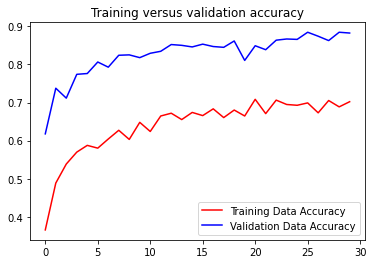

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of training and validation accuracy
get_Accur = wasteImp.history['accuracy']
value_Accur = wasteImp.history['val_accuracy']
get_Los = wasteImp.history['loss']
valid_Los = wasteImp.history['val_loss']
epochs = range(len(get_Accur))

# Table Labels
plt.plot(epochs, get_Accur, 'r', label='Training Data Accuracy')
plt.plot(epochs, value_Accur, 'b', label='Validation Data Accuracy')
plt.title('Training versus validation accuracy')

# Print Table
plt.legend(loc=0)
plt.figure()
plt.show()

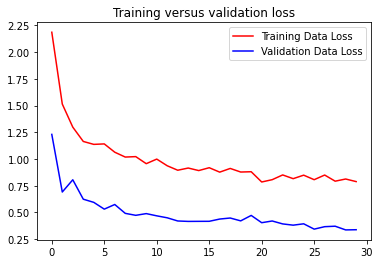

<Figure size 432x288 with 0 Axes>

In [ ]:
# Graphical Results of Loss of Training and Validation
epochs = range(len(get_Los))
plt.plot(epochs, get_Los, 'r', label='Training Data Loss')
plt.plot(epochs, valid_Los, 'b', label='Validation Data Loss')

# Table Labels and Print
plt.title('Training versus validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()